In [1]:
from mycnn import AlexNet
from mycnn import utils
import tensorflow as tf
import numpy as np

In [2]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(227,227),
    batch_size=50,
    label_mode="categorical",
    validation_split=0.2,
    subset="training",
    seed=10
)
train_dataset.map(lambda x, y: (x/255., y))


valid_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(227,227),
    batch_size=50,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)
valid_dataset.map(lambda x, y: (x/255., y))

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


<MapDataset shapes: ((None, 227, 227, 3), (None, 2)), types: (tf.float32, tf.float32)>

In [3]:
alexnet = AlexNet(classes_num=2)
alexnet.summary()

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image (InputLayer)           [(None, 227, 227, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 96)        34944     
_________________________________________________________________
batch_normalization (BatchNo (None, 55, 55, 96)        384       
_________________________________________________________________
re_lu (ReLU)                 (None, 55, 55, 96)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 256)       614656    
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 256)       1024

In [4]:
alexnet.setup_training(
    'log_alexnet',
    epochs=20,
    batch_size=50,  # batch size depend on ImageGenerator
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
alexnet.add_callback(
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.8, patience=10,
        min_lr=0.00001,
        verbose=1
    )
)

******************************
Loading last checkpoint...
Start traing from epoch 20
******************************
checkpoint_path : log_alexnet\weights
best_checkpoint : log_alexnet\weights.h5
epochs          : 20
initial_epoch   : 20
batch_size      : 50
optimizer       : <tensorflow.python.keras.optimizer_v2.gradient_descent.SGD object at 0x0000026B2F440D08>
loss            : categorical_crossentropy
metrics         : ['accuracy']


In [ ]:
alexnet.train_dataset(train_dataset, valid_dataset)

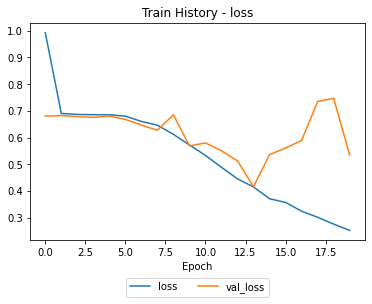

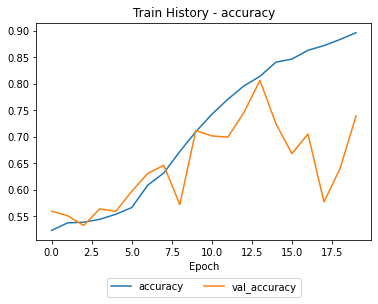

In [5]:
alexnet.show_history(["loss", "accuracy"])

In [ ]:
alexnet.eval_dataset(valid_dataset)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


100%|██████████| 5000/5000 [00:00<00:00, 625175.73it/s]


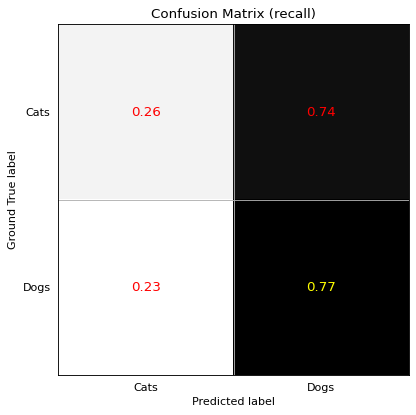

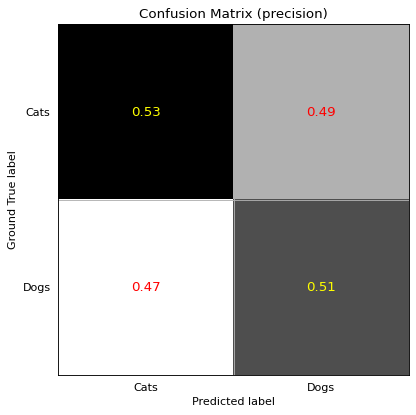

In [5]:
pred_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r'D:\Datasets\DogsVsCats\train',
    image_size=(227,227),
    batch_size=1,
    label_mode="categorical",
    validation_split=0.2,
    subset="validation",
    seed=10
)

pr_score = alexnet.pred_dataset(pred_dataset)
pr_label = pr_score.argmax(axis=-1)

y_test = []
for d in pred_dataset:
    y_test.append(d[1].numpy()[0])
y_test = np.array(y_test)
gt_label = y_test.argmax(axis=-1)

target_names = ["Cats", "Dogs"]

report = utils.export_classification_report(
    gt_label, pr_label, pr_score,
    target_names=target_names,
    logpath=alexnet.logdir
)

cm = report["confusion_matrix"]
cm_precision = cm/cm.sum(axis=0)
cm_recall = cm/cm.sum(axis=1)
utils.plot_confusion_matrix(cm_recall, target_names, alexnet.logdir, title='Confusion Matrix (recall)')
utils.plot_confusion_matrix(cm_precision, target_names, alexnet.logdir, title='Confusion Matrix (precision)')